In [1]:
experiment_name = 'Patients with sepsis in notes'

In [2]:
import json
import os
import random
import sys
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2 as pg
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm, trange

from nfold_roc_auc import plot_roc_auc

%matplotlib inline
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = "42"
connection = pg.connect("host=localhost dbname=MIMIC-III user=postgres password=1027")


In [3]:
queries = json.load(open("queries.json"))


In [4]:
patients = pd.read_csv("cluster_0.csv")
patients

,subject_id,hadm_id
0,4104,161930.0
1,12847,103503.0
2,29495,152287.0
3,26828,194307.0
4,12761,171718.0
...,...,...
5168,48453,NaN
5169,11825,108817.0
5170,70156,NaN
5171,73126,NaN


In [5]:
df = patients.sort_values(by=['subject_id', 'hadm_id'])
df = df.groupby('subject_id').last().reset_index()
df = df.merge(pd.read_csv('patients.csv').drop('subject_id', axis=1), on='hadm_id', how='left')
df

,subject_id,hadm_id,gender,age,admission_type,marital_status,icustay_id,icd9_code,systolic,diastolic,...,lactate,calcium,anion gap,los,admittime,deathtime,delta_deathtime,mortality_30,mortality_60,mortality_90
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,111970.0,0.0,87.753232,1.0,2,216859.0,NaN,98.176471,36.764706,...,NaN,7.700000,15.000000,8.3647,2135-01-30 20:50:00,2135-02-08 02:08:00,8 days 05:18:00,1.0,1.0,1.0
2,33,176176.0,0.0,82.332478,1.0,2,296681.0,NaN,113.538462,48.961538,...,2.700000,8.300000,9.000000,1.5542,2116-12-23 22:30:00,NaN,NaN,0.0,0.0,0.0
3,62,116009.0,0.0,68.711877,1.0,2,216609.0,7140,97.545455,56.909091,...,2.100000,7.833333,10.000000,2.8257,2113-02-15 00:19:00,NaN,NaN,0.0,0.0,0.0
4,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,99469,179324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2138,99726,186684.0,0.0,60.982976,1.0,2,299571.0,NaN,124.965517,71.068966,...,13.521429,7.533333,35.333333,2.6455,2200-11-24 00:46:00,2200-11-26 14:07:00,2 days 13:21:00,1.0,1.0,1.0
2139,99740,161687.0,0.0,51.260119,1.0,2,269160.0,NaN,NaN,NaN,...,NaN,7.466667,15.000000,8.5399,2135-05-01 18:12:00,2135-05-17 15:25:00,15 days 21:13:00,1.0,1.0,1.0
2140,99822,195871.0,0.0,61.251472,1.0,2,297672.0,NaN,108.250000,77.583333,...,2.900000,7.833333,15.333333,4.1091,2197-07-03 02:24:00,2197-07-08 13:15:00,5 days 10:51:00,1.0,1.0,1.0


In [6]:
XY = df[['age', 'asparate aminotransferase', 'mcv', 'alanine aminotransferase', 'urea nitrogen', 'partial prothrombin time', 'prothrombin time', 'rcv', 'lactate', 'albumin', 'total bilirubin', 'mortality_30', 'mortality_60', 'mortality_90']]
XY

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin,mortality_30,mortality_60,mortality_90
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.753232,82.0,99.00,47.0,50.000000,43.50,19.100000,17.700000,NaN,2.10,0.30,1.0,1.0,1.0
2,82.332478,NaN,91.00,NaN,17.500000,NaN,NaN,13.700000,2.700000,NaN,NaN,0.0,0.0,0.0
3,68.711877,NaN,93.75,NaN,20.250000,32.00,13.600000,13.575000,2.100000,NaN,NaN,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2138,60.982976,298.0,99.00,143.0,61.666667,39.00,17.366667,15.833333,13.521429,2.00,4.40,1.0,1.0,1.0
2139,51.260119,309.0,82.00,407.5,17.666667,52.15,42.400000,14.700000,NaN,3.60,21.45,1.0,1.0,1.0
2140,61.251472,NaN,87.50,NaN,19.666667,NaN,NaN,16.200000,2.900000,NaN,NaN,1.0,1.0,1.0


In [7]:
XY.isnull().sum()

age                           749
asparate aminotransferase    1243
mcv                           790
alanine aminotransferase     1243
urea nitrogen                 781
partial prothrombin time      989
prothrombin time              977
rcv                           790
lactate                      1201
albumin                      1438
total bilirubin              1237
mortality_30                  749
mortality_60                  749
mortality_90                  749
dtype: int64

In [8]:
XY = XY.dropna(thresh=len(XY.columns)-1)
XY.isnull().sum()

age                            0
asparate aminotransferase      0
mcv                            0
alanine aminotransferase       0
urea nitrogen                  0
partial prothrombin time       3
prothrombin time               1
rcv                            0
lactate                      135
albumin                      169
total bilirubin                2
mortality_30                   0
mortality_60                   0
mortality_90                   0
dtype: int64

In [9]:
XY.fillna(XY.mean(), inplace=True)
XY

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin,mortality_30,mortality_60,mortality_90
1,87.753232,82.0,99.0,47.0,50.000000,43.500000,19.100000,17.700000,3.064593,2.10,0.300000,1.0,1.0,1.0
11,68.825983,46.0,91.0,57.0,67.666667,30.450000,13.700000,13.000000,1.300000,3.20,1.100000,0.0,0.0,0.0
12,23.850487,22.5,79.0,8.0,5.666667,37.233333,13.766667,18.500000,1.533333,1.90,0.366667,1.0,1.0,1.0
14,76.763182,166.0,100.5,367.5,63.000000,76.066667,19.800000,15.950000,3.064593,2.90,0.650000,1.0,1.0,1.0
18,81.986204,86.5,110.5,104.0,56.000000,29.950000,16.350000,15.100000,3.064593,3.40,4.650000,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133,38.471897,17.0,95.0,12.0,6.000000,39.400000,15.900000,14.800000,0.700000,3.50,2.831810,0.0,0.0,0.0
2136,87.733972,194.0,93.5,304.5,15.500000,37.050000,16.900000,13.750000,1.300000,2.90,2.150000,0.0,0.0,0.0
2138,60.982976,298.0,99.0,143.0,61.666667,39.000000,17.366667,15.833333,13.521429,2.00,4.400000,1.0,1.0,1.0
2139,51.260119,309.0,82.0,407.5,17.666667,52.150000,42.400000,14.700000,3.064593,3.60,21.450000,1.0,1.0,1.0


Text(0.5, 1.01, 'Patients with sepsis in notes')

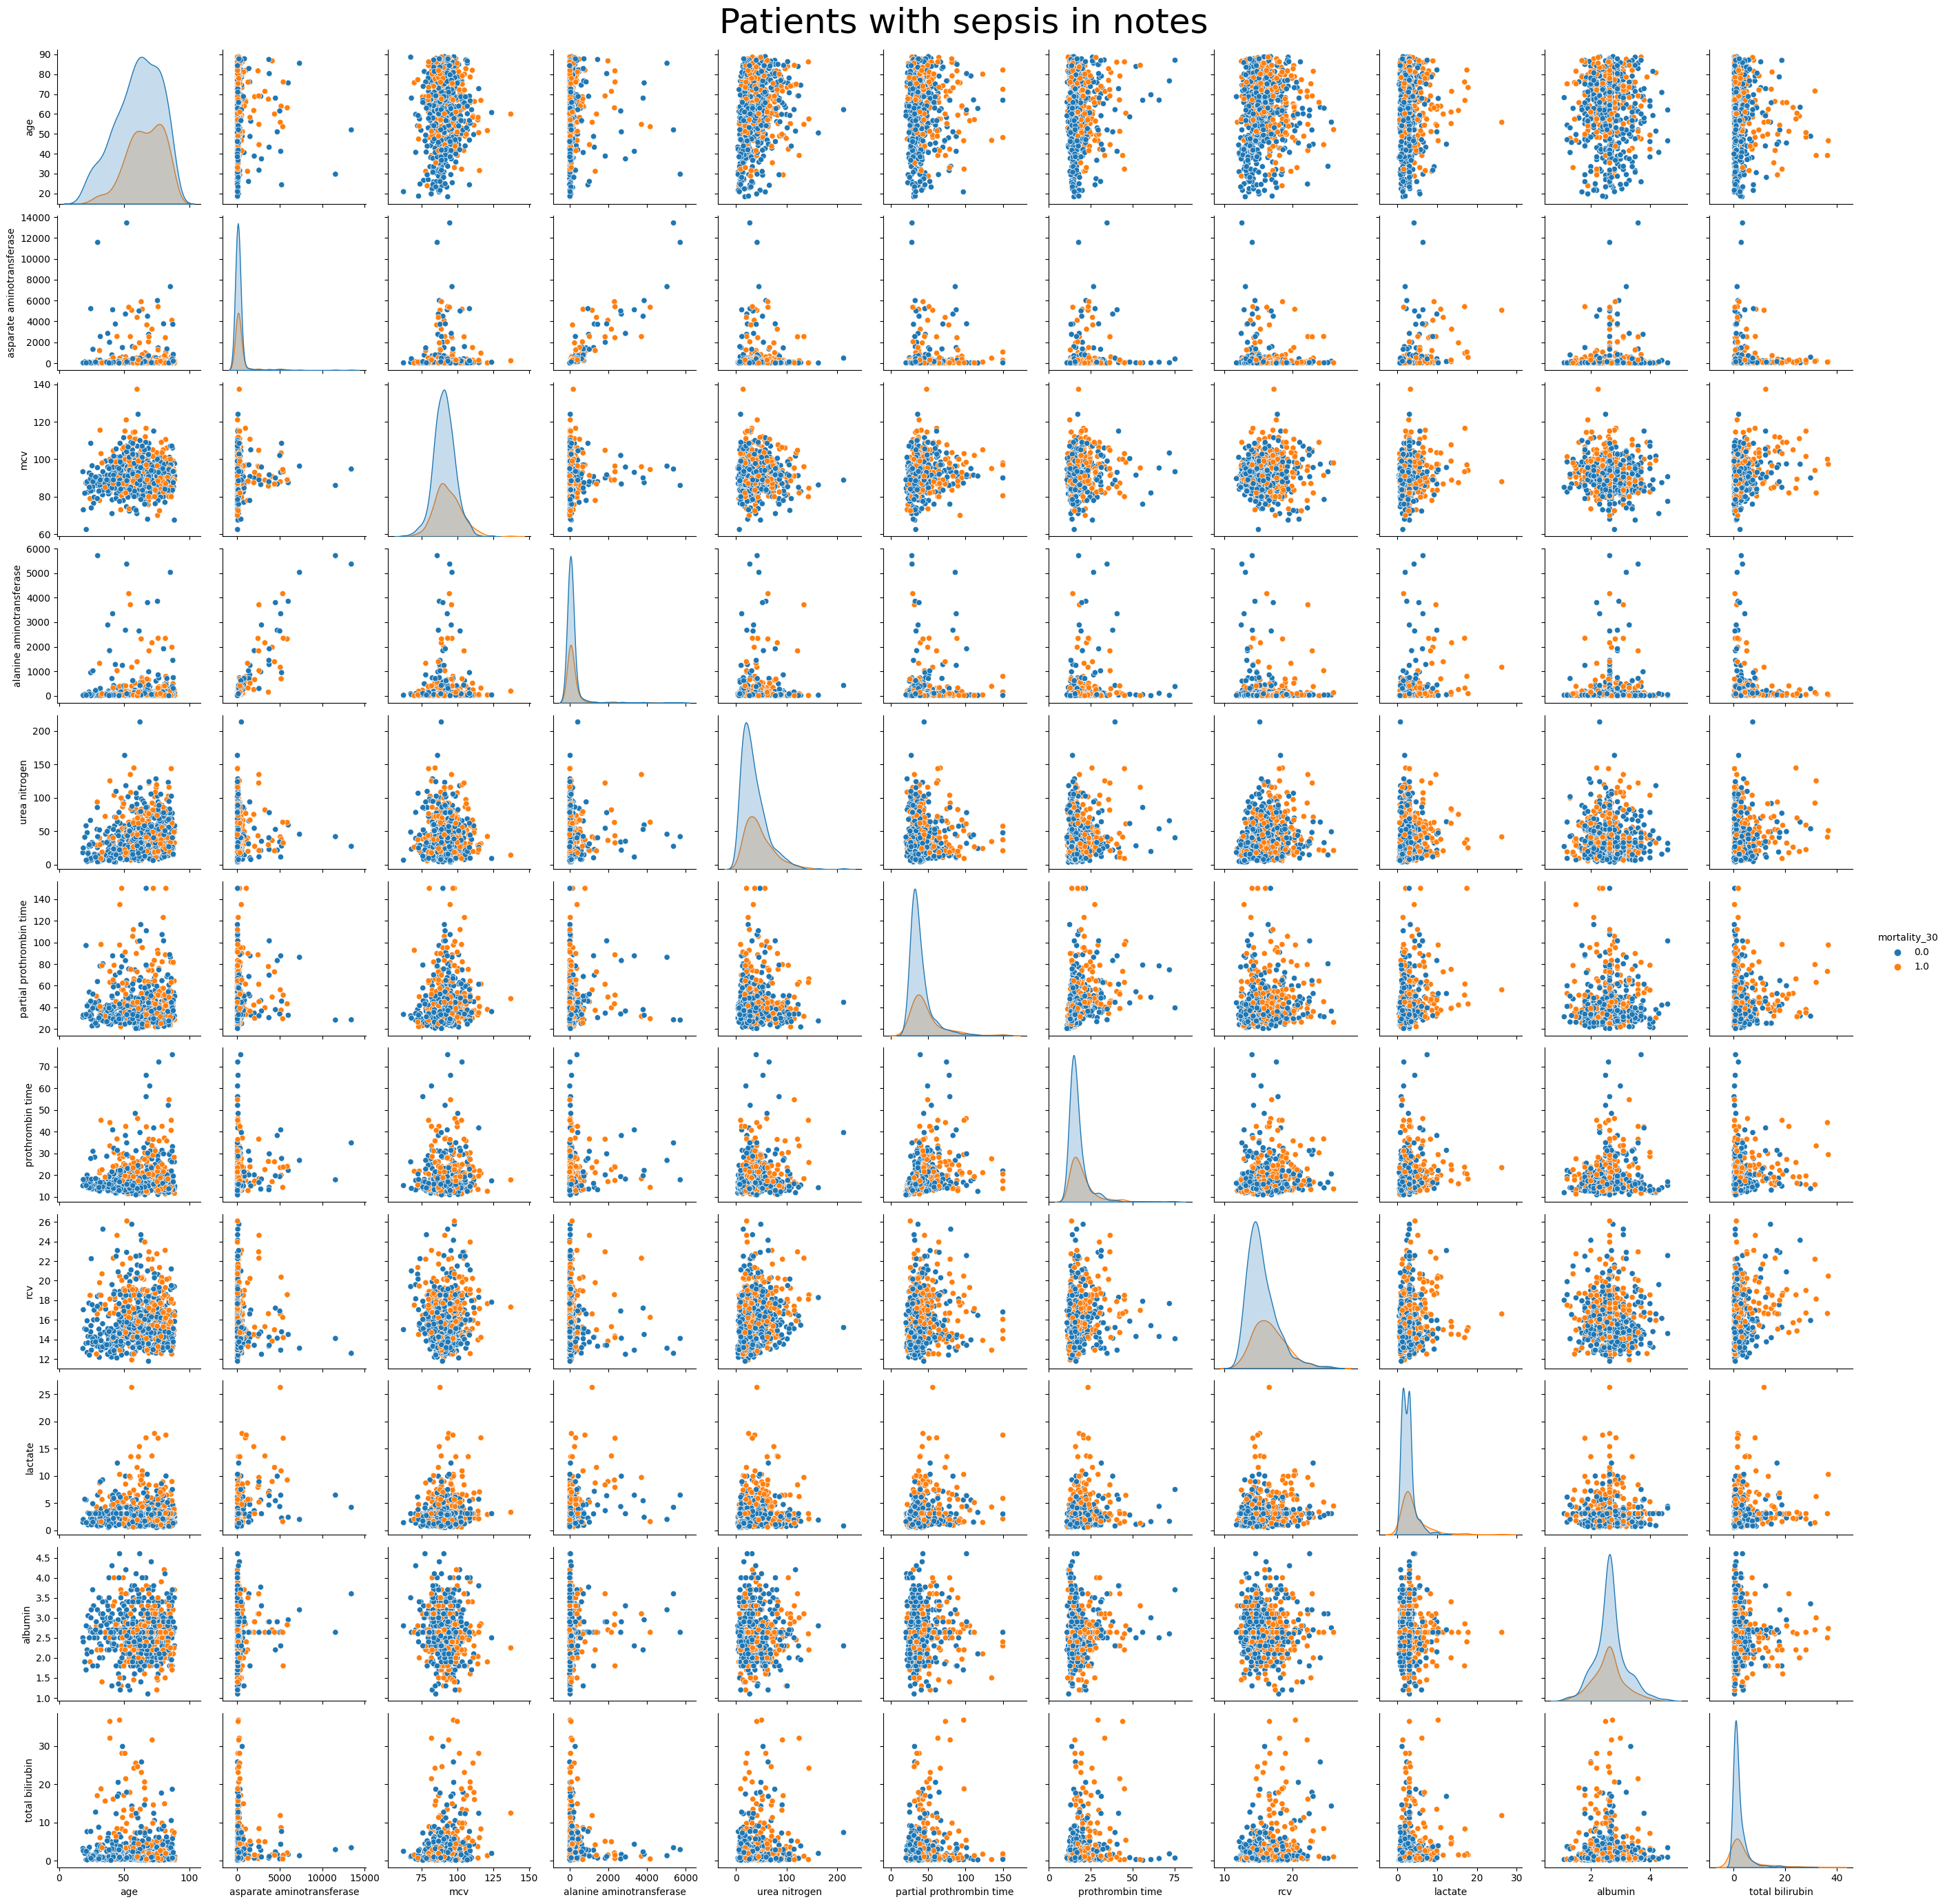

In [10]:
g = sns.pairplot(XY[XY.columns.to_list()[:-2]], hue='mortality_30')
g.fig.suptitle(experiment_name, fontsize=36, y=1.01)

In [11]:
X = XY.drop(["mortality_30", "mortality_60", "mortality_90"], axis=1)
y = XY["mortality_30"]
y_60 = XY["mortality_60"]
y_90 = XY["mortality_90"]
X
X

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin
1,87.753232,82.0,99.0,47.0,50.000000,43.500000,19.100000,17.700000,3.064593,2.10,0.300000
11,68.825983,46.0,91.0,57.0,67.666667,30.450000,13.700000,13.000000,1.300000,3.20,1.100000
12,23.850487,22.5,79.0,8.0,5.666667,37.233333,13.766667,18.500000,1.533333,1.90,0.366667
14,76.763182,166.0,100.5,367.5,63.000000,76.066667,19.800000,15.950000,3.064593,2.90,0.650000
18,81.986204,86.5,110.5,104.0,56.000000,29.950000,16.350000,15.100000,3.064593,3.40,4.650000
...,...,...,...,...,...,...,...,...,...,...,...
2133,38.471897,17.0,95.0,12.0,6.000000,39.400000,15.900000,14.800000,0.700000,3.50,2.831810
2136,87.733972,194.0,93.5,304.5,15.500000,37.050000,16.900000,13.750000,1.300000,2.90,2.150000
2138,60.982976,298.0,99.0,143.0,61.666667,39.000000,17.366667,15.833333,13.521429,2.00,4.400000
2139,51.260119,309.0,82.0,407.5,17.666667,52.150000,42.400000,14.700000,3.064593,3.60,21.450000


In [12]:
y

1       1.0
11      0.0
12      1.0
14      1.0
18      1.0
       ... 
2133    0.0
2136    0.0
2138    1.0
2139    1.0
2141    0.0
Name: mortality_30, Length: 744, dtype: float64

In [13]:
# Oversample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X.values, y.values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.33, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(5), random_state=42)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[117  52]
 [ 40 129]]
              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72       169
         1.0       0.71      0.76      0.74       169

    accuracy                           0.73       338
   macro avg       0.73      0.73      0.73       338
weighted avg       0.73      0.73      0.73       338



In [15]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.5469679579148732 	 0.025516142426371728
F1         0.5054669755416811 	 0.055659727736594666
Recall     0.47142585189415576 	 0.08710492492654452
Precision  0.5586458158313936 	 0.03119149623590336


{'fit_time': array([0.48499727, 0.67799878, 0.67700148, 0.66799951, 0.62400103]),
 'score_time': array([0.00600052, 0.03800154, 0.00200033, 0.05799913, 0.00199962]),
 'test_accuracy': array([0.58536585, 0.50731707, 0.54411765, 0.55882353, 0.53921569]),
 'train_accuracy': array([0.54467564, 0.58017136, 0.54889976, 0.54889976, 0.55134474]),
 'test_f1': array([0.58128079, 0.51207729, 0.40764331, 0.51086957, 0.51546392]),
 'train_f1': array([0.5       , 0.57391304, 0.41889764, 0.50469799, 0.53485425]),
 'test_recall': array([0.57281553, 0.51960784, 0.31372549, 0.46078431, 0.49019608]),
 'train_recall': array([0.45588235, 0.56479218, 0.32518337, 0.4596577 , 0.51589242]),
 'test_precision': array([0.59      , 0.5047619 , 0.58181818, 0.57317073, 0.54347826]),
 'train_precision': array([0.55357143, 0.58333333, 0.58849558, 0.55952381, 0.55526316])}

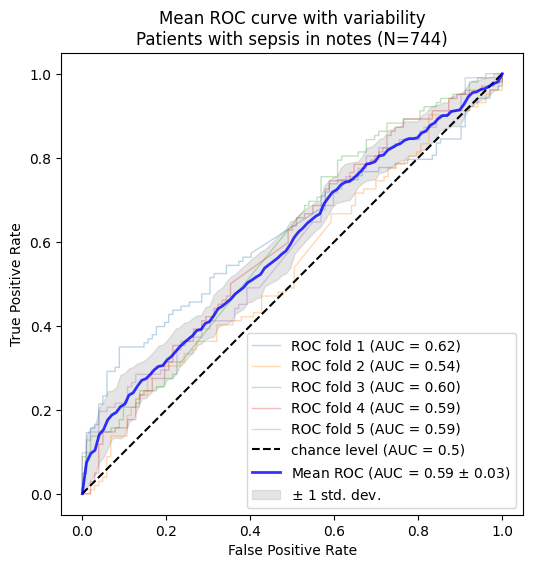

In [16]:
plot_roc_auc(mlp, X_res, y_res, experiment_name, len(XY))

In [17]:
grid = [
    {
        'activation': ['logistic', 'tanh', 'relu'],
        'alpha': [0.0001, 0.0005, 0.001, 0.005],
        'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
        'hidden_layer_sizes': [(5), (10), (20), (5, 5), (10, 10), (20, 20)]
     }
]

grid_search = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

grid_search.best_params_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (20, 20),
 'learning_rate_init': 0.005}

In [18]:
# fine-tuned MLP
mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_["hidden_layer_sizes"],
    random_state=42,
    activation=grid_search.best_params_["activation"],
    alpha=grid_search.best_params_["alpha"],
    learning_rate_init=grid_search.best_params_["learning_rate_init"],
)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[128  41]
 [ 37 132]]
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       169
         1.0       0.76      0.78      0.77       169

    accuracy                           0.77       338
   macro avg       0.77      0.77      0.77       338
weighted avg       0.77      0.77      0.77       338



In [19]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.5871496891439503 	 0.03905338039956403
F1         0.5722008765778102 	 0.10288366583413912
Recall     0.5876451551494384 	 0.19249314199865647
Precision  0.5864120273383153 	 0.038451845335820786


{'fit_time': array([0.06000185, 0.66199899, 0.61800075, 0.57699871, 0.5970006 ]),
 'score_time': array([0.27299976, 0.00400043, 0.00299859, 0.00200105, 0.00199938]),
 'test_accuracy': array([0.51219512, 0.59512195, 0.62254902, 0.6127451 , 0.59313725]),
 'train_accuracy': array([0.58384333, 0.60342717, 0.63814181, 0.66748166, 0.59535452]),
 'test_f1': array([0.38271605, 0.56544503, 0.62068966, 0.60301508, 0.68913858]),
 'train_f1': array([0.43894389, 0.55737705, 0.62531646, 0.64766839, 0.6943675 ]),
 'test_recall': array([0.30097087, 0.52941176, 0.61764706, 0.58823529, 0.90196078]),
 'train_recall': array([0.32598039, 0.49877751, 0.60391198, 0.61124694, 0.9193154 ]),
 'test_precision': array([0.52542373, 0.60674157, 0.62376238, 0.6185567 , 0.55757576]),
 'train_precision': array([0.67171717, 0.63157895, 0.64829396, 0.68870523, 0.5578635 ])}

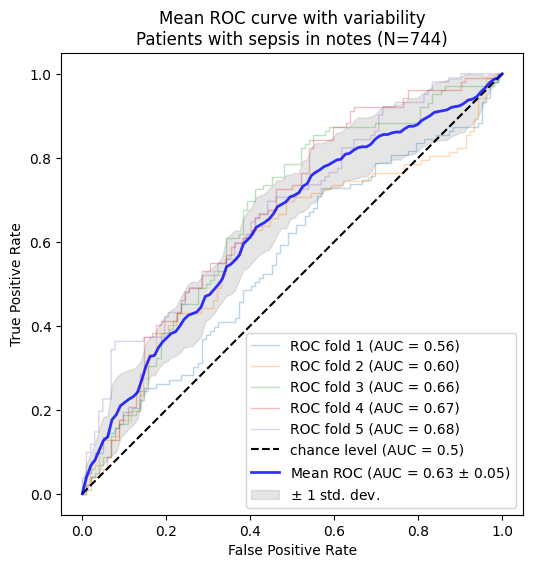

In [20]:
plot_roc_auc(mlp, X_res, y_res, experiment_name, len(XY))

In [21]:
# Oversample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X.values, y_60.values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.33, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

grid_search = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print('best params', grid_search.best_params_)

mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_["hidden_layer_sizes"],
    random_state=42,
    activation=grid_search.best_params_["activation"],
    alpha=grid_search.best_params_["alpha"],
    learning_rate_init=grid_search.best_params_["learning_rate_init"],
)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(5), random_state=42)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
best params {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.01}
[[112  49]
 [ 53 108]]
              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69       161
         1.0       0.69      0.67      0.68       161

    accuracy                           0.68       322
   macro avg       0.68      0.68      0.68       322
weighted avg       0.68      0.68      0.68       322



In [22]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.5379592915675391 	 0.0417304045716497
F1         0.5176352050655455 	 0.042689887814159534
Recall     0.4969282558384179 	 0.05368358271733442
Precision  0.5432329129789324 	 0.04716112542375406


{'fit_time': array([0.56599975, 0.82000089, 1.3509984 , 0.61299992, 0.29999566]),
 'score_time': array([0.00199771, 0.00299883, 0.00400162, 0.00300002, 0.00200057]),
 'test_accuracy': array([0.54871795, 0.47179487, 0.57948718, 0.57948718, 0.51030928]),
 'train_accuracy': array([0.54428755, 0.58151476, 0.53530167, 0.5648267 , 0.53076923]),
 'test_f1': array([0.55555556, 0.44919786, 0.56842105, 0.51764706, 0.4973545 ]),
 'train_f1': array([0.51962111, 0.55945946, 0.52741514, 0.53877551, 0.53076923]),
 'test_recall': array([0.56122449, 0.42857143, 0.55670103, 0.45360825, 0.48453608]),
 'train_recall': array([0.49357326, 0.53213368, 0.51794872, 0.50769231, 0.53076923]),
 'test_precision': array([0.55      , 0.47191011, 0.58064516, 0.60273973, 0.51086957]),
 'train_precision': array([0.54857143, 0.58974359, 0.53723404, 0.57391304, 0.53076923])}

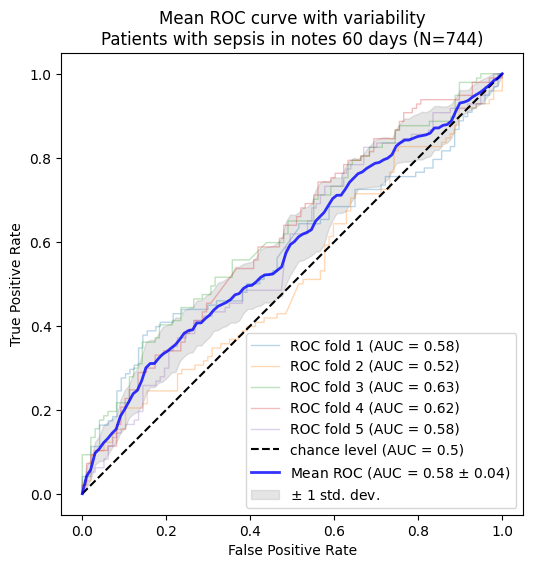

In [23]:
plot_roc_auc(mlp, X_res, y_res, experiment_name + ' 60 days', len(XY))